# Hyperopt-Sklearn: Really Simple Hyperparameter Optimization
by Matthew Emery [@lstmemery](https://github.com/lstmemery/hyperopt-sklearn/tree/master/hpsklearn)

## About Me

- Master's degree from UBC in Data Science
- Data scientist at Imbellus Inc.
- We build simulations to predict the problem solving abilities of job applicants
- I also do occasional consulting: matthew.emery44@gmail.com

## Table of Questions

1. What are hyperparameters?
2. Why should I care about this talk?
3. How does the Tree Parzen Estimator algorithm work?
4. What does Hyperopt do?
5. Why should I use Hyperopt-Sklearn?
6. What are my other options?

In [2]:
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, accuracy_score, make_scorer
import pandas as pd
import numpy as np
import hyperopt as hp
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from random import randint
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import scikitplot as skplt
import warnings
from sklearn.externals import joblib
from sklearn.neighbors import KNeighborsClassifier
from hpsklearn import HyperoptEstimator, any_classifier
warnings.filterwarnings('ignore')
import pandas as pd
from collections import defaultdict
from numpy.random import uniform, choice, seed, normal, binomial
import seaborn as sns
from scipy.stats import truncnorm

%matplotlib inline
np.set_printoptions(precision=2, suppress=True)

X1, y1 = make_regression(n_samples=1000, noise=2, n_features=10, n_informative=5, random_state=0)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=0)

X2, y2 = make_regression(n_samples=1000, noise=2, n_features=1000, n_informative=5, random_state=100)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=100)

/home/deadhand/.local/share/virtualenvs/hyperopt-pydata-MbHnsSDw/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/deadhand/.local/share/virtualenvs/hyperopt-pydata-MbHnsSDw/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


## What Are Those Machines Learning?

- Machine learning algorithms find the **parameters** of a model that minimize some **loss function**
- Every algorithm comes with a different set of assumptions about your data
- You can modify the algorithm's assumptions before you minimize by setting **hyperparameters**

In [43]:
ols = Lasso(alpha = 0.0001) # Alpha is a hyperparameter
ols.fit(X1_train, y1_train)
print(ols.coef_) # Regression coefficients are parameters
print(f"Score: {mean_absolute_error(y1_test, ols.predict(X1_test)):.2f}")

lasso = Lasso(alpha = 1)
lasso.fit(X1_train, y1_train)
print(lasso.coef_)
print(f"Score: {mean_absolute_error(y1_test, lasso.predict(X1_test)):.2f}")

[52.44  0.06 73.27 -0.06  9.66 13.49 -0.03 -0.05  0.16 40.06]
Score: 1.70
[51.41  0.   72.26 -0.    8.76 12.45 -0.   -0.    0.   38.98]
Score: 2.35


- I generated two synthetic data sets for regression
- First has 10 features, 5 are informative
- Second has 1000 features, with 5 informative
- Lasso with weak regression does better here

In [57]:
# Same generating process, but more uninformative features
ols = Lasso(alpha = 0.0001)
ols.fit(X2_train, y2_train)
print(f"Score: {mean_absolute_error(y2_test, ols.predict(X2_test)):.2f}")

lasso = Lasso(alpha = 1)
lasso.fit(X2_train, y2_train)
print(f"Score: {mean_absolute_error(y2_test, lasso.predict(X2_test)):.2f}")

Score: 41.83
Score: 2.51


- Even though the processes that made these data sets are similar, the results are radically similar
- Talk about No Free Lunch here

## Are an experimental composer?

![http://www.retrothing.com/2015/01/vintage-synthesizer-reissues-invade-namm-2015.html](./img/synthesizer.png)

- Imagine that you've been instructed to recreate a 5 minute song on this synth
- Some of the knobs and switches affect others. Some don't do anything at all
- You don't really know what you're doing, but a blind DJ tells you how close you are

- This is what hyperparameter tuning is like
- It takes a long time
- It's frusterating to do by had
- You don't get a lot of feedback

- The combination of all hyperparameters is called **Hyperparameter Space**

### What do we know about Hyperparameter Space?

1. It's very big. You can expect to be exploring in dozens of dimensions
2. It's costly to explore. Each point in hyperparameter space has to be evaluated by training a model
3. It's not smooth. You can't expect to take the gradient of hyperparameter space
4. Not all dimensions are equal. There are often hyperparameters whose optimal values don't contribute very much minimizing the loss function.
5. (Because of the first 4): Humans are bad exploring it. Randomized search often outperforms humans. [1]

- Taking gradient is nice because it gives you a sense of direction
- Very recent work has found some clever ways for you to take the derivative of something like hyperparameter space

## Side-Note: Optimization Bias and Getting Rich Quick[5]
- Every week day for two weeks (10 days) I send you an email predicting whether the Dow Jones will rise or fall
- I'm always right

Assuming the Dow Jones Index is independent and equally likely to rise or fall:

$$\Big(\frac{1}{2}\Big)^{10} = \frac{1}{1024}$$

- Is there anything you should know before you give me all your money?

## How many different emails did I send?

- If I sent out random emails to 10000 different people it becomes a lot less impressive

In [8]:
emails = binomial(n=10, p=0.5, size=10000)
len(emails[emails == 10]) # Nine lucky recipients!

9

Make sure to mention How Not to Be Wrong

## What does this have to do with hyperparamater optimization?
- Each email is a model that gives a prediction
- The emailer is your hyperparameter optimization algorithm
- The first 10 days if your validation set
- You lose all your money by putting a crappy model in production

## How do we defeat optimization bias?

1. **Get more data:** This is almost always a good call.
2. **Cross-validation:** This is like asking the stock picker to predict the direction of multiple indices. Optimization bias will still happen but it will be more slowly. Repeat cross-validation with different seeds if you can afford to.
3. **Build fewer models:** This is why the efficiency of the hyperparameter optimization algorithm matters

- Hyperparameter optimization is computationally costly
- Your ideal hyperparameters will shift depending on feature engineering
- Create a few basic models first and see if validation accuracy improves
- **Don't do hyperparameter tuning until you are reasonably certain you won't be making big changes**

- It's tempting to run this all the time. You shouldn't
- I think of hyperparameter tuning as sending your model off to get laminated

## Dessert First: Let's Peek at Hyperopt-Sklearn

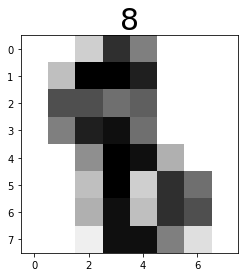

In [13]:
X, y = load_digits(return_X_y = True) # MNIST Dataset

(train_X, test_X, train_y, test_y) = train_test_split(X, y, 
                                     test_size = 0.2,
                                     random_state = 0) # Split the Data 
random_image = randint(0, len(train_X))
plt.title(train_y[random_image], fontsize=30)
plt.imshow(train_X[random_image].reshape(8, 8), cmap=plt.cm.gray_r)

- This is interactive in the notebook version
- I've loaded all the all the libraries ahead of time

0.944


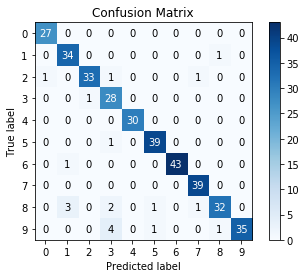

In [11]:
model = RandomForestClassifier(random_state = 0) # Basic Random Forest
model.fit(train_X, train_y)
print(accuracy_score(test_y, model.predict(test_X)).round(3))

skplt.metrics.plot_confusion_matrix(test_y, model.predict(test_X)) # Lookup Scikit-plot! 

- This is already really good. (About 1 in 20 wrong)
- I just love scikit-plot

In [37]:
from hpsklearn import HyperoptEstimator, any_classifier

hyperopt_model = HyperoptEstimator(classifier=any_classifier("mnist"),
                                   max_evals=100,
                                   seed=0)
hyperopt_model.fit(train_X,
              train_y,
              n_folds=5,
              cv_shuffle=True,
              random_state=0)

from sklearn.externals import joblib

joblib.dump(hyperopt_model, "hyperopt_model.pkl")

['hyperopt_model.pkl']

- This took about 30 minutes to run
- I normally run stuff like this overnight or in the cloud
- ALWAYS SAVE YOUR WORK
- You can also specify specific classifiers you want

0.989
{'learner': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance'), 'preprocs': (Normalizer(copy=True, norm='l2'),), 'ex_preprocs': ()}


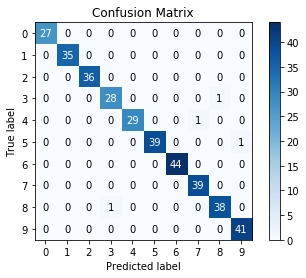

In [14]:
hyperopt_model = joblib.load("hyperopt_model.pkl")
hyperopt_predictions = hyperopt_model.predict(test_X)

print(accuracy_score(test_y, hyperopt_predictions).round(3))
print(hyperopt_model.best_model())
skplt.metrics.plot_confusion_matrix(test_y, hyperopt_predictions)

- We are now up to getting only 1 in 100 wrong
- If you are familar with MNIST, this model happens to be a really solid solution

In [ ]:
classifier_types = ["svc", "knn", "random\nforest", "extra\ntrees", "ada\nboost", "gradient\nboosting", "sgd"]

classifier_performance = defaultdict(list)
for index, classifier in enumerate(hyperopt_model.trials.trials):
    classifier_performance["index"].append(index)
    classifier_performance["loss"].append(1 - classifier["result"]["loss"]) # We want accuracy
    classifier_performance["classifier_type"].append(classifier_types[classifier['misc']['vals']["mnist"][0]])

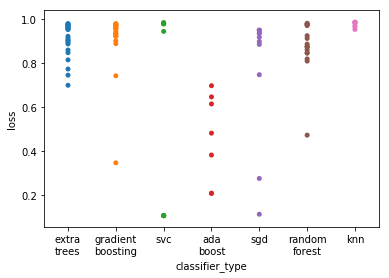

In [19]:
sns.stripplot(x="classifier_type", y="loss", data= pd.DataFrame(classifier_performance))

- This is a plot of performance for the different algorithms tried
- What you can see is some models clearly outperform others
- Why is gradient boosting fine but adapative not? Who knows

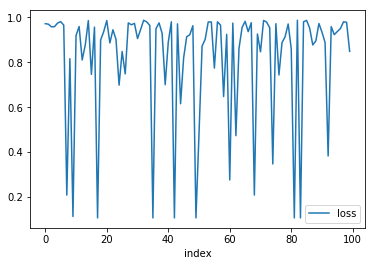

In [20]:
pd.DataFrame(classifier_performance).plot.line(x="index", y="loss")

- In this case the problem was rather easy so you don't notice a huge trend
- Over time those deep dips will start to disappear
- That wouldn't happen in random search

## Sequential Model-Based Optimization (SMBO)

```
Make a container for your history
For each time step in the total number of time steps
    Find the most promising set of hyperparameters based off a *surrogate function* and your *model of the data*
    Evaluate your most promising set with your true, expensive function
    Update your history
    Update your model of the data, given the new history
```

- Here comes the math
- Begestra did a huge amount of work here
- SMBO is a general framework. We have to make up the surrogate function and model

## How should we model the data?

Original paper suggests two options:

1. Gaussian Processes (Maybe next talk?)
2. **Tree-based Parzen Windows (TPE)**

- Gaussian processes tend to work well with continuous variables
- GPs tend to fail when you have a lot of features that don't matter
- Hyperparameter optimization is still a very open field

## What Is a Surrogate Function?

- A surrogate function attempts to put foward the best proposal for the true function
- The one chosen in the original paper is called expected improvement, but there are other proposals

$$EI_{y^*}(x) = \int_{-\infty}^{\infty} \max(y^* - y, 0) p(y|x) dy$$

- $y^*$ is some threshold value. $p(y|x)$ is the probability of achieving the loss $y$ given the hyperparameters $x$ 
- In TPE it's a quantile cutoff point of previous values

## How do Tree-Based Parzen Estimators Work?
- Imagine you have two distributions
- One distribution contains all of the sets of hyperparameters that give good results
- The other contains all the sets of hyperparameters that are not good

$$p(x|y) = \Big\{^{l(x) if y \lt y^*}_{g(x) if y \geq y^*}$$
- Notice that we are modeling $p(x|y)$, not $p(y|x)$, but we have Bayes' thereom

## What decides $y^*$?

- You do! It's a hyper-hyperparameter
- The TPE algorithm contains a parameter $\gamma$.
- $\gamma$ = $p(y \lt y^*)$
- This represents the proportion of "good" $y$s
- By default it's 15%

## What are $l(x)$ and $g(x)$?

- They start as some prior distribution (uniform, log-uniform, normal, log-normal or discrete)
- If the prior is continuous then the prior distribution is replaced by truncated 1D Gaussian mixture
- If the prior is discrete, then add some weight to the value selected
- As far as I can tell, $l$ is for lesser and $g$ is for greater

## What is the TPE algorithm actually optimizing?

- Begestra[1] shows that

$$EI_y^*(x) \propto \Big(\gamma + \frac{g(x)}{l(x)}(1-\gamma)\Big)^{-1}$$

- The best point $x^*$ will appear be highly probable in $l(x)$ and highly improbable in $g(x)$
- So find the optimal point $x^*$ we sample $x$ in both mixtures and report the the value that minimizes $\frac{g(x)}{l(x)}$
- Gaussian mixtures are easy to calculate, so this sampling operation is fast

## What is a Gaussian Mixture?

- Imagine adding two Gaussian curves together and normalizing

### In TPE:
- The mean of each Gaussian is defined as the point sampled from the previous distribution
- The standard deviation is the difference between the new sampled point and it's immediate neighbours. Pick the greater of the two distances.

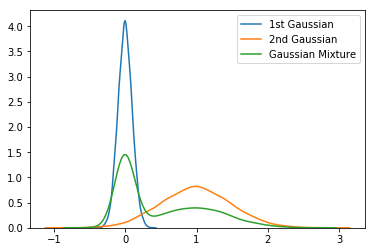

In [112]:
gaussian_example_1 = normal(loc=0, scale=0.1, size=10000)
gaussian_example_2 = normal(loc=1, scale=0.5, size=10000)
mixture_example = choice(np.concatenate([gaussian_example_1, gaussian_example_2]), size = len(gaussian_example_1))

sns.distplot(gaussian_example_1, kde=True, hist=False, label="1st Gaussian")
sns.distplot(gaussian_example_2, kde=True, hist=False, label="2nd Gaussian")
sns.distplot(mixture_example, kde=True, hist=False, label="Gaussian Mixture")

- TPE constructs these mixtures iteratively

## What is Hyperopt?

- People assume that hyperopt is the reference implementation of TPE in Python[4]
- That's true, but it's also a general purpose optimization framework

We need:
 - A function to minimize
 - A defined hyperparameter space
 - A object to store our experiments in
 - A search algorithm (TPE)

In [10]:
def example_experiment(space_arguments):    
    # Recall MNIST from near the start of the talk?
    accuracy_results = cross_val_score(space_arguments, 
                                       train_X, train_y, scoring=make_scorer(accuracy_score))
    
    try:
        return {"loss": -accuracy_results.mean(), # Negative because hyperopt always minimizes
         "status": hp.STATUS_OK}
    except Exception as e:
        return {"status": hp.STATUS_FAIL,
                "exception": str(e)} 

In [11]:
hp.pyll.scope.define(RandomForestClassifier)
hp.pyll.scope.define(KNeighborsClassifier)


space = hp.hp.pchoice("model", [
    (0.4, hp.pyll.scope.RandomForestClassifier( # Weighted discrete
        criterion=hp.hp.choice("random_forest.criterion", ["gini", "entropy"]),
        n_estimators=hp.pyll.scope.int(
            hp.hp.qloguniform("random_forest.n_estimators", np.log(9.5), np.log(3000.5), 1)))),
    (0.6, hp.pyll.scope.KNeighborsClassifier(
        n_neighbors=hp.pyll.scope.int(hp.hp.qloguniform("knn.n_neighbors", np.log(0.5), np.log(50.5), 1))))
])

- scope.define makes a function accessible to the space
- pchoice is weighted discrete
- qloguniform just rounds a log-uniform (can't be negative)

In [14]:
trials = hp.Trials() # Basicially, a dictionary
best = hp.fmin(example_experiment, 
               space, 
               algo=hp.tpe.suggest, max_evals=10, trials=trials)
best
trials.trials[0]

{'knn.n_neighbors': 3.0, 'model': 1}

## What is Hyperopt-Sklearn? [3]

![https://www.semanticscholar.org/paper/Hyperopt-Sklearn%3A-Automatic-Hyperparameter-for-Komer-Bergstra/7b2ce6eb25ab840936ae6bf2cd49bc7f20785bc4](./img/tpe_structure.png)

- A wrapper for Hyperopt compatible with the scikit-learn API
- Also includes reasonable prior distributions for many scikit-learn models (plug and play)
- Supports XGBoost
- Checkout my fork of it is here: https://github.com/lstmemery/hyperopt-sklearn
- My main contribution: Fixing cross-validation, adding repeated cross-validation

This is a way of visualizing hyperopt-sklearn. It selects a preprocessor randomly, then selects the hyperparameters for the preprocessor. This comes image comes from hyperopt-sklearn paper

## Other Features

- Parallel Optimization through MongoDB
- Warm Starting (don't start from square one every time)

- These are both ways of dealing with larger datasets
- When in doubt, just buy a bigger instance

## What about Neural Networks?

- Some kind soul built a keras-compatibility layer called [Hyperas](https://github.com/maxpumperla/hyperas)
- Hyperas has a similar syntax to Jinja or any other HTML templating library
- I haven't found anything for PyTorch

## Other Hyperparameter Libraries

- Hyperband (subsampling, bandit algorithm random search)
- TPOT (Evolutionary pipeline building)
- Auto-sklearn (Ensemble building and meta-learning)

## Bibliography

[1]J. Bergstra, R. Bardenet, Y. Bengio, and B. Kégl, “Algorithms for Hyper-parameter Optimization,” in Proceedings of the 24th International Conference on Neural Information Processing Systems, USA, 2011, pp. 2546–2554.

[2]D. D. Labs, “District Data Labs - Parameter Tuning with Hyperopt.” [Online]. Available: https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt. [Accessed: 15-Jul-2018].

[3]B. Komer, J. Bergstra, and C. Eliasmith, “Hyperopt-Sklearn: Automatic Hyperparameter Conﬁguration for Scikit-Learn,” p. 7, 2014.

[4]J. Bergstra, B. Komer, C. Eliasmith, D. Yamins, and D. D. Cox, “Hyperopt: a Python library for model selection and hyperparameter optimization,” Comput. Sci. Disc., vol. 8, no. 1, p. 014008, 2015.

[5]J. Ellenberg, How Not to Be Wrong: The Power of Mathematical Thinking. Penguin Books, 2014.